<a href="https://colab.research.google.com/github/VMBoehm/ML_Lectures/blob/main/ImprovingVAEs_and_VAEs_on_imperfect_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Introduction to Variational AutoEncoders (VAEs) and applications to physical data** 

by Vanessa Boehm (UC Berkeley and LBNL)   
Feb 27 2022

Let' start by importing a few packages, that we will need later

In [31]:
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import Normalize

In [32]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Use this line to confirm the location of your files

In [33]:
! ls drive/MyDrive/ML_lecture_data/

Decoder_model_weights.pth	   DR16_train.npy
DR16_denoised_inpainted.npy	   Encoder_model_weights.pth
DR16_denoised_inpainted_test.npy   VAE
DR16_denoised_inpainted_train.npy  VAE_encoder
DR16_test.npy			   VAE_model_weights.pth


Let's set some immutable variables:
The dimensionality of the input data and the dimensionality of the latent (encoded) space

In [34]:
INPUT_SIZE      = 1000
LATENT_SIZE     = 4

Next we create pytorch datasets from the training and test data (note that you need to change the root_dir, if you placed the data in a different folder)

In [35]:
class SDSS_DR16(Dataset):
    """De-redshifted and downsampled spectra from SDSS-BOSS DR16"""

    def __init__(self, root_dir='drive/MyDrive/ML_lecture_data/', transform=True, train=True):
        """
        Args:
            root_dir (string): Directory of data file
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        if train:
            self.data = np.load(open(os.path.join(root_dir,'DR16_denoised_inpainted_train.npy'),'rb'),allow_pickle=True)
        else:
            self.data = np.load(open(os.path.join(root_dir,'DR16_denoised_inpainted_test.npy'),'rb'),allow_pickle=True)
        self.data = torch.as_tensor(self.data)
        self.mean = torch.mean(self.data)
        self.std  = torch.std(self.data)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = (self.data[idx]-self.mean)/self.std

        return sample


training_data = SDSS_DR16(train=True)
test_data     = SDSS_DR16(train=False)

In [36]:
#TASK: Familiarize yourself with torch.distribution.Normal - you can find the documentation here: https://pytorch.org/docs/stable/distributions.html#normal
#HINT: It takes a standard deviation (scale) not a variance as input
from torch.distributions import Normal as Normal
from torch.distributions import MultivariateNormal as MultivariateNormal 

In [37]:
class RealNVP_Transform(nn.Module):
    def __init__(self, binary_mask):
        super().__init__()
        self.size         = len(binary_mask)
        # scale factors
        self.mask         =  binary_mask[None,:].float()
        self.inverse_mask = (~binary_mask[None,:]).float()
        # shift factors
        self.fc1_s        = torch.nn.Linear(self.size,self.size)
        self.fc2_s        = torch.nn.Linear(self.size,self.size)
        self.fc1_b        = torch.nn.Linear(self.size,self.size)
        self.fc2_b        = torch.nn.Linear(self.size,self.size)


    def network_s(self,x):
        x = self.fc1_s(x)
        x = torch.nn.LeakyReLU()(x)
        x = self.fc2_s(x)
        x = torch.clip(x,-5,5)
        x = x*self.inverse_mask
        return x

    def network_t(self,x):
        x = self.fc1_b(x)
        x = torch.nn.LeakyReLU()(x)
        x = self.fc1_b(x)
        x = x*self.inverse_mask
        return x

    def forward(self, u):
        masked_input = u*self.mask
        input        = u*self.inverse_mask
        s            = self.network_s(masked_input)
        t            = self.network_t(masked_input)
        z            = torch.exp(s)*input+t
        log_detJ     = torch.sum(s, axis=-1)
        z            = self.inverse_mask*z+masked_input
        return z, log_detJ

    def inverse(self,z):
        masked_input = z*self.mask
        input        = z*self.inverse_mask
        s            = self.network_s(masked_input)
        t            = self.network_t(masked_input)
        u            = (input-t)/torch.exp(s)
        log_detJ_inv = -torch.sum(s,axis=-1)
        u            = self.inverse_mask*u+masked_input
        return u, log_detJ_inv

class FlowModel(nn.Module):
    def __init__(self, layers, dim):
        super().__init__()
        self.dim      = dim
        self.layers   = nn.ModuleList(layers)
        self.depth    = len(self.layers)
        self.p_u      = MultivariateNormal(torch.zeros(self.dim), torch.eye(self.dim))

    def forward(self,u):
        for ii, layer in enumerate(self.layers):
          if ii ==0:
            z, det = self.layers[ii].forward(u)
          else:
            z, det_ = self.layers[ii].forward(z)
            det+=det_
        return z, det

    def inverse(self,z):
        for ii in np.arange(self.depth-1,-1,-1):
          if ii ==(self.depth-1):
            u, inv_det = self.layers[ii].inverse(z)
          else:
            u, inv_det_ = self.layers[ii].inverse(u)
            inv_det+=inv_det_
        return u, inv_det

    def log_prob(self,z):
        shape        = z.shape
        z            = z.reshape(-1,self.dim)
        u, inv_det   = self.inverse(z)
        log_prob     = self.p_u.log_prob(u)
        log_prob+=inv_det
        return log_prob.reshape(shape[:-1])

    def rsample(self, N_samples):
        u        = self.p_u.rsample(N_samples)
        for layer in self.layers:
            z, log_det = layer.forward(u)
        return z

In [38]:
NLAYERS = 8
if LATENT_SIZE%2==0:
  mask    = np.append(np.zeros(LATENT_SIZE//2),np.ones(LATENT_SIZE//2))
else:
  mask    = np.append(np.zeros(LATENT_SIZE//2+1),np.ones(LATENT_SIZE//2))

masks= []
for ii in range(NLAYERS):
  np.random.shuffle(mask)
  masks.append(torch.as_tensor(mask).bool())
print(masks)
layers  = [RealNVP_Transform(masks[ii]) for ii in range(NLAYERS)]
FM      = FlowModel(layers, LATENT_SIZE)

[tensor([ True, False, False,  True]), tensor([False, False,  True,  True]), tensor([False, False,  True,  True]), tensor([ True,  True, False, False]), tensor([False, False,  True,  True]), tensor([False, False,  True,  True]), tensor([ True,  True, False, False]), tensor([ True, False, False,  True])]


In [39]:
FM.log_prob(torch.ones(5,10,LATENT_SIZE)*np.arange(LATENT_SIZE, dtype=np.float32)[None,None,:])

tensor([[-8.0106, -8.0106, -8.0106, -8.0106, -8.0106, -8.0106, -8.0106, -8.0106,
         -8.0106, -8.0106],
        [-8.0106, -8.0106, -8.0106, -8.0106, -8.0106, -8.0106, -8.0106, -8.0106,
         -8.0106, -8.0106],
        [-8.0106, -8.0106, -8.0106, -8.0106, -8.0106, -8.0106, -8.0106, -8.0106,
         -8.0106, -8.0106],
        [-8.0106, -8.0106, -8.0106, -8.0106, -8.0106, -8.0106, -8.0106, -8.0106,
         -8.0106, -8.0106],
        [-8.0106, -8.0106, -8.0106, -8.0106, -8.0106, -8.0106, -8.0106, -8.0106,
         -8.0106, -8.0106]], grad_fn=<ReshapeAliasBackward0>)

In [40]:
for name, param in FM.named_parameters():
    if param.requires_grad:
        print(name)

layers.0.fc1_s.weight
layers.0.fc1_s.bias
layers.0.fc2_s.weight
layers.0.fc2_s.bias
layers.0.fc1_b.weight
layers.0.fc1_b.bias
layers.0.fc2_b.weight
layers.0.fc2_b.bias
layers.1.fc1_s.weight
layers.1.fc1_s.bias
layers.1.fc2_s.weight
layers.1.fc2_s.bias
layers.1.fc1_b.weight
layers.1.fc1_b.bias
layers.1.fc2_b.weight
layers.1.fc2_b.bias
layers.2.fc1_s.weight
layers.2.fc1_s.bias
layers.2.fc2_s.weight
layers.2.fc2_s.bias
layers.2.fc1_b.weight
layers.2.fc1_b.bias
layers.2.fc2_b.weight
layers.2.fc2_b.bias
layers.3.fc1_s.weight
layers.3.fc1_s.bias
layers.3.fc2_s.weight
layers.3.fc2_s.bias
layers.3.fc1_b.weight
layers.3.fc1_b.bias
layers.3.fc2_b.weight
layers.3.fc2_b.bias
layers.4.fc1_s.weight
layers.4.fc1_s.bias
layers.4.fc2_s.weight
layers.4.fc2_s.bias
layers.4.fc1_b.weight
layers.4.fc1_b.bias
layers.4.fc2_b.weight
layers.4.fc2_b.bias
layers.5.fc1_s.weight
layers.5.fc1_s.bias
layers.5.fc2_s.weight
layers.5.fc2_s.bias
layers.5.fc1_b.weight
layers.5.fc1_b.bias
layers.5.fc2_b.weight
layers.5.fc2

In the next cell we set the training parameters, define the loss function and create DataLoaders. Pytorch DataLoaders manage the data loading for us (break the dataset into batches, keep track of epochs, reshuffle the data after each epoch) 

In [41]:
class VAEEncoder(nn.Module):

    def __init__(self, seed=853):
        super(VAEEncoder, self).__init__()
        # TASK: change the output size of the encoder network. How many parameters must it return to define q(z|x)?
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(INPUT_SIZE,50)
        self.fc2 = nn.Linear(50,LATENT_SIZE*2)

    def forward(self, x):
        # TASK: change the output of the encoder network. Instead of just returning z, it should return z and ...?
        # HINT: Don't forget that the standard deviation/variance must be strictly positive!
        # HINT: You might want to use torch.split()
        x      = torch.nn.LeakyReLU()(self.fc1(x))
        x      = self.fc2(x)
        mu,std = torch.split(x, LATENT_SIZE,dim=-1)
        #print(torch.min(mu), torch.max(mu), torch.min(std), torch.max(std))
        std    = torch.exp(std) + 1e-8
        return mu, std


In [42]:
class VAEDecoder(nn.Module):

    def __init__(self, seed=620):
        super(VAEDecoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(LATENT_SIZE,50)
        self.fc2 = nn.Linear(50,INPUT_SIZE)

    def forward(self, z):
        z = torch.nn.LeakyReLU()(self.fc1(z))
        x = self.fc2(z)
        return x

In [71]:
class VariationalAutoencoder(nn.Module):
    #TASK: add parameters mentioned in point 1. 
    def __init__(self, sample_size, sigma):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VAEEncoder()
        self.decoder = VAEDecoder()
        self.sample_size = sample_size
        self.sigma       = sigma
        #TASK: Use the Normal class to define the prior (a standard normal distribution), p(z)
        self.prior       = FlowModel(layers, LATENT_SIZE)

    def change_sample_size(self,sample_size):
        self.sample_size = sample_size
        return True

    def get_q(self,x):
        #TASK: write a method that computes q(z,x)
        #HINT: use the Normal class we imported above
        mu, std = self.encoder(x)
        self.q  = Normal(mu, std)
        return True

    def sample_q(self):
        #TASK: write a method that samples from q
        #HINT: use rsample to apply the reparameterization trick
        z_sample = self.q.rsample(torch.Size([self.sample_size]))
        #z_sample = torch.reshape(z_sample,[-1,LATENT_SIZE])
        #print(z_sample.shape)
        return z_sample

    def get_log_likelihood(self,recons,x):
        ll    = Normal(x[None,:,:], self.sigma)
        log_p = ll.log_prob(recons)
        log_p = torch.sum(log_p,dim=-1)
        return log_p

    def get_avg_log_likelihood(self,recons,x):
        #TASK: Write a method that returns the first term in the ELBO (this method should define the likelihood and evaluate the average log likelihood of the reconstruction)
        #HINT: Pay attention to shapes. The function should return an average log likelihood (a single number) for every data point in the batch.
        #HINT: The output shape of Normal(mu, sigma).log_prob() is a little unintuitive. If mu or sigma are N-dimensional, it returns N results (applies N independent Gaussians). 
        #HINT: You need to average over samples from q to obtain the final result.
        log_p = self.get_log_likelihood(self,recons,x)
        return torch.mean(log_p,dim=0)

    def stochastic_kl_divergence(self,z_sample):
        #print(self.q.log_prob(z_sample).shape,self.prior.log_prob(z_sample).shape)
        #TASK: write a method that computes the kl-divergence between q(z|x) and p(z) 
        return torch.mean(torch.sum(self.q.log_prob(z_sample),dim=-1)-self.prior.log_prob(z_sample), dim=0)

    def forward(self, x):
        #TASK: a forward pass should return the two terms in the ELBO
        #HINT: use all methods we defined above
        self.get_q(x)
        samples = self.sample_q()
        recons  = self.decoder(samples)
        log_likelihood = self.get_avg_log_likelihood(recons,x)
        kl      = self.stochastic_kl_divergence(samples)
        return log_likelihood, kl

### **STEP 3**: Prepare for training

In [51]:
BATCHSIZE       = 128
BATCHSIZE_TEST  = 128
LEARNING_RATE   = 1e-3

#TASK: create an instance of the Variational Autoencoder
VAE = VariationalAutoencoder(sample_size=16,sigma=0.1)

optimizer = torch.optim.Adam(VAE.parameters(), lr=LEARNING_RATE)


# Dataloaders
train_dataloader = DataLoader(training_data, batch_size=BATCHSIZE, shuffle=True)
test_dataloader  = DataLoader(test_data, batch_size=BATCHSIZE_TEST, shuffle=True)

In [52]:

for name, param in VAE.named_parameters():
    if param.requires_grad:
        print(name)

encoder.fc1.weight
encoder.fc1.bias
encoder.fc2.weight
encoder.fc2.bias
decoder.fc1.weight
decoder.fc1.bias
decoder.fc2.weight
decoder.fc2.bias
prior.layers.0.fc1_s.weight
prior.layers.0.fc1_s.bias
prior.layers.0.fc2_s.weight
prior.layers.0.fc2_s.bias
prior.layers.0.fc1_b.weight
prior.layers.0.fc1_b.bias
prior.layers.0.fc2_b.weight
prior.layers.0.fc2_b.bias
prior.layers.1.fc1_s.weight
prior.layers.1.fc1_s.bias
prior.layers.1.fc2_s.weight
prior.layers.1.fc2_s.bias
prior.layers.1.fc1_b.weight
prior.layers.1.fc1_b.bias
prior.layers.1.fc2_b.weight
prior.layers.1.fc2_b.bias
prior.layers.2.fc1_s.weight
prior.layers.2.fc1_s.bias
prior.layers.2.fc2_s.weight
prior.layers.2.fc2_s.bias
prior.layers.2.fc1_b.weight
prior.layers.2.fc1_b.bias
prior.layers.2.fc2_b.weight
prior.layers.2.fc2_b.bias
prior.layers.3.fc1_s.weight
prior.layers.3.fc1_s.bias
prior.layers.3.fc2_s.weight
prior.layers.3.fc2_s.bias
prior.layers.3.fc1_b.weight
prior.layers.3.fc1_b.bias
prior.layers.3.fc2_b.weight
prior.layers.3.fc2

In [53]:
for name, param in FM.named_parameters():
    if param.requires_grad:
        print(name)

layers.0.fc1_s.weight
layers.0.fc1_s.bias
layers.0.fc2_s.weight
layers.0.fc2_s.bias
layers.0.fc1_b.weight
layers.0.fc1_b.bias
layers.0.fc2_b.weight
layers.0.fc2_b.bias
layers.1.fc1_s.weight
layers.1.fc1_s.bias
layers.1.fc2_s.weight
layers.1.fc2_s.bias
layers.1.fc1_b.weight
layers.1.fc1_b.bias
layers.1.fc2_b.weight
layers.1.fc2_b.bias
layers.2.fc1_s.weight
layers.2.fc1_s.bias
layers.2.fc2_s.weight
layers.2.fc2_s.bias
layers.2.fc1_b.weight
layers.2.fc1_b.bias
layers.2.fc2_b.weight
layers.2.fc2_b.bias
layers.3.fc1_s.weight
layers.3.fc1_s.bias
layers.3.fc2_s.weight
layers.3.fc2_s.bias
layers.3.fc1_b.weight
layers.3.fc1_b.bias
layers.3.fc2_b.weight
layers.3.fc2_b.bias
layers.4.fc1_s.weight
layers.4.fc1_s.bias
layers.4.fc2_s.weight
layers.4.fc2_s.bias
layers.4.fc1_b.weight
layers.4.fc1_b.bias
layers.4.fc2_b.weight
layers.4.fc2_b.bias
layers.5.fc1_s.weight
layers.5.fc1_s.bias
layers.5.fc2_s.weight
layers.5.fc2_s.bias
layers.5.fc1_b.weight
layers.5.fc1_b.bias
layers.5.fc2_b.weight
layers.5.fc2

In [54]:
#TASK: define the new loss function
def negative_ELBO(avg_log_likelihood,kl, beta):

    negative_ELBO = - torch.mean(avg_log_likelihood-beta*kl)

    return negative_ELBO

In [55]:
def train_loop(dataloader, model, loss_fn, optimizer, beta=1):
    size = len(dataloader.dataset)
    losses = []
    for batch, X in enumerate(dataloader):
        #TASK: compute the loss from the output of the VAE foward pass  
        log_likelihood, kl = model(X)
        loss = loss_fn(log_likelihood,kl, beta)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0, norm_type=2)
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            losses.append(loss)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        #assert(False)

    #scheduler.step()
    return losses


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, nllh, kl_ = 0, 0, 0
    #model.eval()
    with torch.no_grad():
        for X in dataloader:
            #TASK: in the test loop we want to keep track not only of the ELBO, but also of the two terms that contribute to the ELBO (kl diveregence and loglikelihood)
            log_likelihood, kl = model(X)
            test_loss += loss_fn(log_likelihood,kl,beta=1).item()
            nllh += -np.mean(log_likelihood.cpu().numpy())
            kl_ += np.mean(kl.cpu().numpy())


    test_loss /= num_batches
    kl_ /= num_batches
    nllh /= num_batches

    print(f" Avg test loss      : {test_loss:>8f}")
    print(f" Avg KL             : {kl_:>8f}")
    print(f" Avg negative log likelihood : {nllh:>8f} \n")

    return test_loss, kl_, nllh


Let's train!

In [56]:
EPOCHS = 10

train_loss = []
test_loss  = []
beta_init  = 100
for t in range(EPOCHS):
    beta = beta_init#max(beta_init*(EPOCHS-t),1)
    print(beta)
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss.append(train_loop(train_dataloader, VAE, negative_ELBO, optimizer,beta))
    test_loss.append(test_loop(test_dataloader, VAE, negative_ELBO))
print("Done!")

100
Epoch 1
-------------------------------
loss: 14787213312.000000  [    0/100000]
loss: 237.436401  [12800/100000]
loss: -118.195518  [25600/100000]
loss: -262.951904  [38400/100000]
loss: -646.851379  [51200/100000]
loss: -335.150635  [64000/100000]
loss: -682.848572  [76800/100000]
loss: -653.702576  [89600/100000]
 Avg test loss      : -439.816317
 Avg KL             : 368.580581
 Avg negative log likelihood : -808.396914 

100
Epoch 2
-------------------------------
loss: -645.414246  [    0/100000]
loss: 830.895386  [12800/100000]
loss: -803.225220  [25600/100000]
loss: -98.397736  [38400/100000]
loss: -601.924194  [51200/100000]
loss: -588.511169  [64000/100000]
loss: -721.082397  [76800/100000]
loss: -798.750122  [89600/100000]
 Avg test loss      : -1034.784597
 Avg KL             : 4.477256
 Avg negative log likelihood : -1039.261854 

100
Epoch 3
-------------------------------
loss: -783.838501  [    0/100000]
loss: -524.315979  [12800/100000]
loss: -501.882446  [25600/10

In [57]:
test_loss=np.asarray(test_loss)

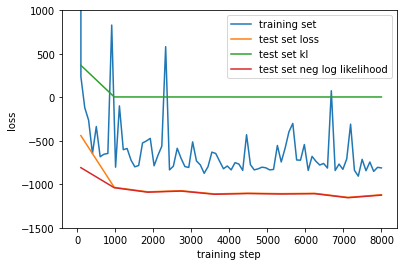

In [64]:
#TASK: plot the training loss, test loss, and the contributions to teh loss from each of the two terms 
length = len(np.asarray(train_loss).flatten())
plt.figure()
plt.plot(np.linspace(0,length*100,length), np.asarray(train_loss).flatten(),label='training set')
plt.plot(np.linspace(100,(length)*100,len(test_loss)),test_loss[:,0],label='test set loss')
plt.plot(np.linspace(100,(length)*100,len(test_loss)),test_loss[:,1],label='test set kl')
plt.plot(np.linspace(100,(length)*100,len(test_loss)),test_loss[:,2],label='test set neg log likelihood')
plt.xlabel('training step')
plt.ylabel('loss')
plt.ylim(-1500,1000)
plt.legend()
plt.show()

In [65]:
# TASK: Inspect how the contribution of the kl divergence and log likelihood to the loss change as you change the noise in the likelihood. Some suggested values: sigma=[0.5,1,2]
# TASK: what ahppens if you change the number of samples?
# What do you observe? Can you interpret it?

### **STEP 4:** Inspect the model performance

Similar to the AE, we will look at the average reconstruction quality. But in addition, we also want to know how well the kl term was minimized. We will therefore look at three things

1.   Reconstruction quality
2.   Scatter plots of posterior samples and prior samples. Recall that $p(z)=\int \mathcal{d}x\, p(x,z) \approx \frac{1}{N_{samples}} \sum_{x\sim p(x)} p(z|x)$.
3.   Quality of artificial data generation


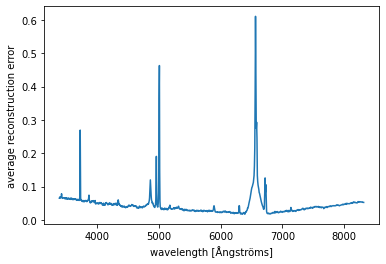

In [66]:
# This is the mapping from pixel to the de-redshifted (rest) wavelength
wlmin, wlmax      = (3388,8318)
fixed_num_bins    = 1000
wl_range          = (np.log10(wlmin),np.log10(wlmax))
wl                = np.logspace(wl_range[0],wl_range[1],fixed_num_bins) 
 
 #TASK: plot the average reconstruction error of the model as a function of wavelength (similar to above). How does it compare to the Autoencoder?
 #HINT: Use the mean of $q(z|x)$ as the latent point for data x
avg_loss  = 0
VAE.eval()
with torch.no_grad():
    for X in test_dataloader:
        pred = VAE.decoder(VAE.encoder(X)[0])
        avg_loss+=np.mean((pred.cpu().numpy()-X.cpu().numpy())**2,axis=0)/(len(test_data)//BATCHSIZE_TEST)

plt.figure()
plt.plot(wl, np.sqrt(avg_loss))
plt.ylabel('average reconstruction error')
plt.xlabel('wavelength [Ångströms]')
plt.show()

(30000, 4)
(30080, 4)


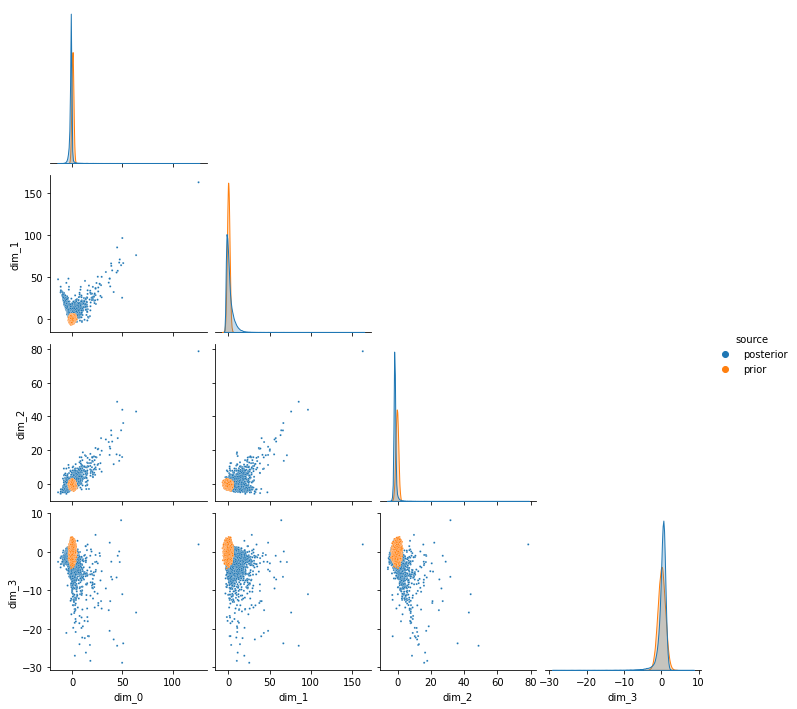

In [67]:
#TASK: make a corner plot of posterior samples. Does the average posterior match the prior?

import seaborn as sns
import pandas as pd

VAE.eval()
with torch.no_grad():
    for ii, X in enumerate(test_dataloader):
        VAE.get_q(X)
        prior_sample = VAE.prior.rsample([BATCHSIZE_TEST])
        sample       = VAE.sample_q().cpu().numpy()[0:1].swapaxes(0,1)
        if ii==0:
          samples       = sample
          prior_samples = prior_sample
        else:
          samples       = np.vstack([samples, sample])
          prior_samples = np.vstack([prior_samples, prior_sample])

samples       = np.reshape(samples,[-1, LATENT_SIZE])
prior_samples = np.reshape(prior_samples,[-1, LATENT_SIZE])

print(samples.shape)
print(prior_samples.shape)

data1    = pd.DataFrame()
data2    = pd.DataFrame()

for ii in range(LATENT_SIZE):
  data1['dim_%d'%ii] = samples[:,ii]
data1['source'] = 'posterior'

for ii in range(LATENT_SIZE):
  data2['dim_%d'%ii] = prior_samples[:,ii]
data2['source'] = 'prior'

data = pd.concat([data1,data2]).reset_index(drop=True)


#HINT: to get a density estimate you can set kind='kde', but you'll probably have to reduce the number of samples, or try 'hist' instead
sns.pairplot(data,corner=True,kind='scatter', hue='source', plot_kws={'s':2})
plt.show()

In [68]:
torch.save(VAE.state_dict(), 'drive/MyDrive/ML_lecture_models/ImprovedVAE_model_weights.pth')

In [69]:
#TASK: Generate artificial data: sample from the prior and foward model the sample thorugh the decoder. Do the samples look realistic? Why?/Why not?

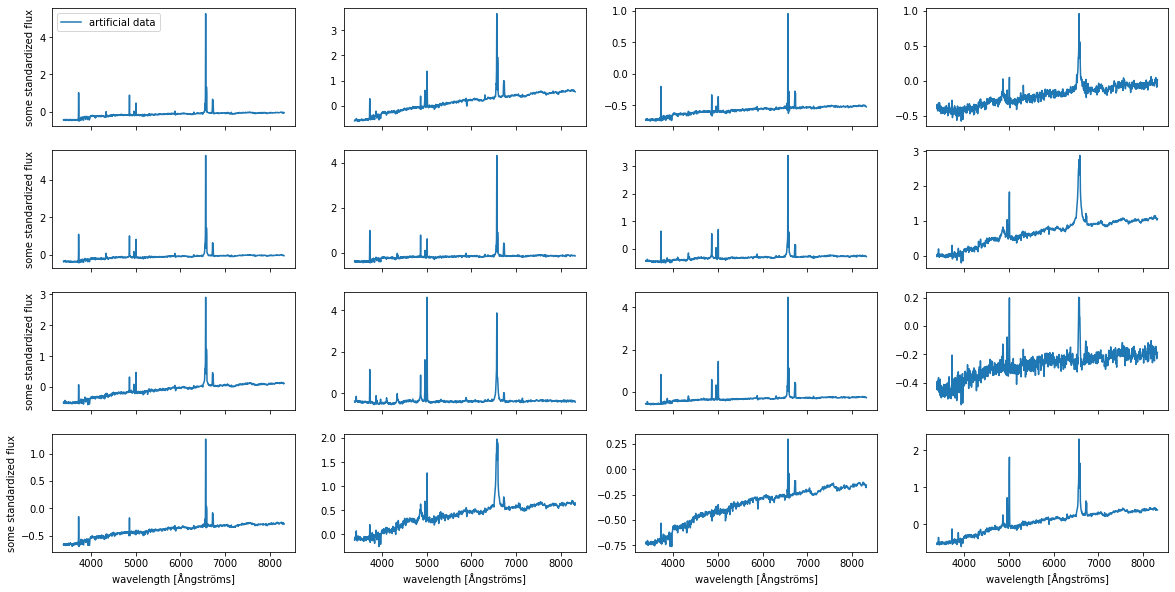

In [70]:
VAE.eval()
with torch.no_grad():
  samples = VAE.prior.rsample([16])
  data_samples = VAE.decoder(samples)



fig, ax = plt.subplots(4,4, figsize=(20,10), sharex=True)
ax = ax.flatten()
for ii in range(16):
  ax[ii].plot(wl,data_samples[ii], label='artificial data')
  if ii in np.arange(12,16):
    ax[ii].set_xlabel('wavelength [Ångströms]')
  if ii in [0,4,8,12]:
    ax[ii].set_ylabel('some standardized flux')
  if ii==0:
    ax[ii].legend()
plt.show()

In [ ]:
# real posterior is p(z|x)~p(z,x)=p(z)*p(x|z)

def compute_joint(VAE, x,z):
  recon = VAE.decoder(z)
  llh   = VAE.log_likelihood(recon,x)
  lpz   = VAE.prior.log_prob(z)
  return llh+lpz